In [2]:
import h5py
import matplotlib.pyplot as plt
import torch
import pandas as pd
import numpy as np

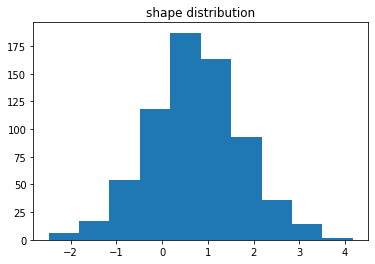

In [2]:
with h5py.File("../features/shapef.h5", "r") as fs:
    df = pd.DataFrame(fs["shape"])
    df = df[df != 0]
    plt.hist(df)
    plt.title("shape distribution")
    plt.show()

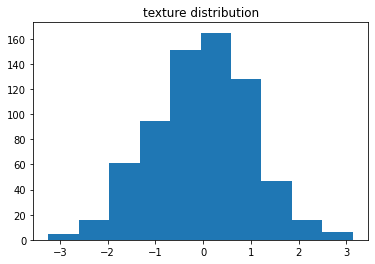

In [3]:
with h5py.File("../features/texturef.h5", "r") as ft:
    df = pd.DataFrame(ft["texture"])
    df = df[df != 0]
    plt.hist(df)
    plt.title("texture distribution")
    plt.show()

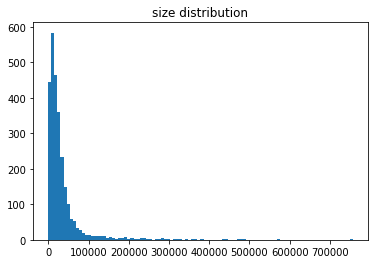

In [6]:
with h5py.File("../features/sizef.h5", "r") as ft:
    df = pd.DataFrame(ft["size"])
    plt.hist(df, bins=100)
    plt.title("size distribution")
    plt.show()



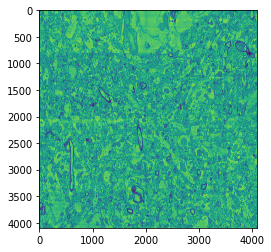

In [3]:
with h5py.File("../outputs/neuroglancer.h5", "r") as ng:
    ds = ng["images"]
    plt.imshow(ds[0])